In [4]:
import os 
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split    
from keras.utils import to_categorical


In [5]:
data_dir = 'data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

print(sorted(classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
X = []
y = []

for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    print(f'{c}: {len(files)}')

    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        img = img.resize((28, 28))
        img = np.array(img)
        img = img / 255
        img = img.astype(np.float32)
        # Check the shape of the image after resizing
        print(img.shape)
        X.append(img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

9: 100
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 

In [7]:
# print the shape of the arrays
print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Save the data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('classes.npy', classes)

print('Data saved')


(1000, 28, 28, 4)
(1000,)
Data saved


In [8]:
# Load the data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy')

print('Data loaded')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(sorted(classes))



Data loaded
(800, 28, 28, 4)
(200, 28, 28, 4)
(800, 10)
(200, 10)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


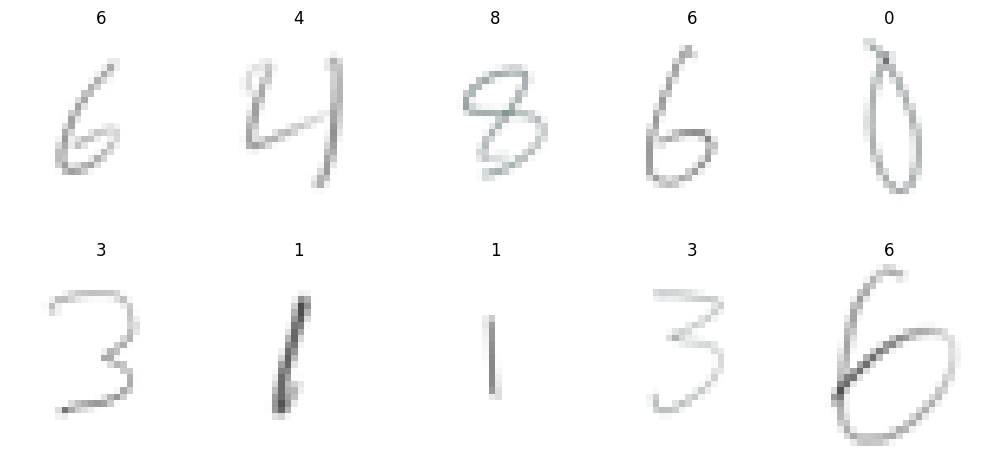

In [9]:
# print a random sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()